<a href="https://colab.research.google.com/github/Manuuflorez/BigData/blob/main/Taller_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [354]:
# MANUELA FLOREZ RODRIGUEZ

In [387]:
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import tree

In [356]:
warnings.filterwarnings("ignore")

In [357]:
# Leer el archivo Excel.
dataset = pd.read_excel("BBDD_Hospitalización.xlsx")

In [358]:
dataset.describe()

,EDAD,PSA,NUMERO DE MUESTRAS TOMADAS,DIAS HOSPITALIZACION MQ,DIAS HOSPITALIZACIÓN UPC
count,568.000000,564.000000,568.000000,568.000000,568.000000
mean,63.882042,13.271401,12.996479,0.165493,0.014085
std,9.281517,15.668966,3.921180,0.958066,0.196474
min,39.000000,0.600000,4.000000,0.000000,0.000000
25%,59.000000,5.600000,12.000000,0.000000,0.000000
50%,64.000000,8.000000,12.000000,0.000000,0.000000
75%,69.000000,15.000000,12.000000,0.000000,0.000000
max,151.000000,100.000000,24.000000,12.000000,3.000000


In [359]:
# Eliminar filas con valores ilógicos en las variables seleccionadas
dataset = dataset[(dataset['EDAD'] > 0) & (dataset['EDAD'] <= 100)]  # EDAD dentro de un rango razonable

In [360]:
# Eliminar las variables no relevantes.
# La variable CUP no contribuye directamente al objetivo de estudio, no es relevante para el análisis.
# Las variables DIAS HOSPITALIZACION MQ y DIAS HOSPITALIZACIÓN UPC son menos relevantes para la predicción de la hospitalización.
# Las variables TIPO DE CULTIVO y PATRON DE RESISTENCIA están más relacionadas con el tratamiento de la infección que con la predicción de la hospitalización.
dataset = dataset.drop(['CUP', 'TIPO DE CULTIVO', 'PATRON DE RESISTENCIA',
                        'DIAS HOSPITALIZACION MQ', 'DIAS HOSPITALIZACIÓN UPC'], axis=1)

In [361]:
# Mostrar la cantidad de nulos.
print(dataset.isnull().sum())

EDAD                                                                          0
DIABETES                                                                      0
HOSPITALIZACIÓN ULTIMO MES                                                    0
PSA                                                                           4
BIOPSIAS PREVIAS                                                              2
VOLUMEN PROSTATICO                                                            1
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                       0
NUMERO DE MUESTRAS TOMADAS                                                    0
ENF. CRONICA PULMONAR OBSTRUCTIVA                                             2
BIOPSIA                                                                       0
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA     0
FIEBRE                                                                        0
ITU                                     

In [362]:
# Eliminar filas con valores nulos en la variable HOSPITALIZACION ya que es la variable objetivo.
dataset = dataset.dropna(subset=['HOSPITALIZACION'])
print(dataset.isnull().sum())

EDAD                                                                          0
DIABETES                                                                      0
HOSPITALIZACIÓN ULTIMO MES                                                    0
PSA                                                                           4
BIOPSIAS PREVIAS                                                              2
VOLUMEN PROSTATICO                                                            1
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                       0
NUMERO DE MUESTRAS TOMADAS                                                    0
ENF. CRONICA PULMONAR OBSTRUCTIVA                                             2
BIOPSIA                                                                       0
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA     0
FIEBRE                                                                        0
ITU                                     

In [363]:
# Reemplazaremos los valores nulos con la mediana de cada columna, ya que es una medida menos sensible a valores atípicos.
# Imputación de valores para columnas numéricas, se saca la mediana de cada dato y se reemplazan los nulos.
median_edad = dataset['EDAD'].median()
median_psa = dataset['PSA'].median()

dataset['EDAD'].fillna(median_edad, inplace=True)
dataset['PSA'].fillna(median_psa, inplace=True)

In [364]:
# Reemplazaremos los valores nulos con el valor más frecuente de cada columna, ya que es una manera adecuada de mantener la
# distribución de los datos.
# Imputación de valores para columnas categóricas, se busca el valor mas frecuente de cada dato y se reemplazan los nulos.
mode_enf = dataset['ENF. CRONICA PULMONAR OBSTRUCTIVA'].mode()[0]
mode_volumen_prostatico = dataset['VOLUMEN PROSTATICO'].mode()[0]
mode_biopsias = dataset['BIOPSIAS PREVIAS'].mode()[0]
mode_agente = dataset['AGENTE AISLADO'].mode()[0]

dataset['ENF. CRONICA PULMONAR OBSTRUCTIVA'].fillna(mode_enf, inplace=True)
dataset['AGENTE AISLADO'].fillna(mode_agente, inplace=True)
dataset['BIOPSIAS PREVIAS'].fillna(mode_biopsias, inplace=True)
dataset['VOLUMEN PROSTATICO'].fillna(mode_volumen_prostatico, inplace=True)

In [365]:
# Verificación de nulos
print(dataset.isnull().sum())

EDAD                                                                         0
DIABETES                                                                     0
HOSPITALIZACIÓN ULTIMO MES                                                   0
PSA                                                                          0
BIOPSIAS PREVIAS                                                             0
VOLUMEN PROSTATICO                                                           0
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                      0
NUMERO DE MUESTRAS TOMADAS                                                   0
ENF. CRONICA PULMONAR OBSTRUCTIVA                                            0
BIOPSIA                                                                      0
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA    0
FIEBRE                                                                       0
ITU                                                 

In [366]:
# Mapear variables categóricas a valores numéricos.
mapeo_diabetes = {'NO': 0, 'SI': 1}
mapeo_hospitalizacionMes = {'NO': 0, 'SI': 1}
mapeo_biopsiaPrev = {'NO': 0, 'SI': 1}
mapeo_volProst = {'NO': 0, 'SI': 1}
mapeo_fiebre = {'NO': 0, 'SI': 1}
mapeo_itu = {'NO': 0, 'SI': 1}
mapeo_hospitalizacion = {'NO': 0, 'SI': 1}

# Actualizacion de las variables utilizando el mapeo.
dataset['DIABETES'] = dataset['DIABETES'].map(mapeo_diabetes)
dataset['HOSPITALIZACIÓN ULTIMO MES'] = dataset['HOSPITALIZACIÓN ULTIMO MES'].map(mapeo_hospitalizacionMes)
dataset['BIOPSIAS PREVIAS'] = dataset['BIOPSIAS PREVIAS'].map(mapeo_biopsiaPrev)
dataset['VOLUMEN PROSTATICO'] = dataset['VOLUMEN PROSTATICO'].map(mapeo_volProst)
dataset['FIEBRE'] = dataset['FIEBRE'].map(mapeo_fiebre)
dataset['ITU'] = dataset['ITU'].map(mapeo_itu)
dataset['HOSPITALIZACION'] = dataset['HOSPITALIZACION'].map(mapeo_hospitalizacion)

In [367]:
# Codificar variables categóricas como variables binarias utilizando la técnica one-hot encoding.
dataset = pd.get_dummies(dataset, columns=['ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS', 'ENF. CRONICA PULMONAR OBSTRUCTIVA',
                                           'BIOPSIA', 'AGENTE AISLADO'])

In [368]:
# Lista de columnas seleccionadas como características para el modelo.
feature_cols = ['EDAD', 'DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'PSA', 'BIOPSIAS PREVIAS', 'VOLUMEN PROSTATICO',
                'NUMERO DE MUESTRAS TOMADAS', 'FIEBRE', 'ITU', 'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_CEFALOSPORINA_AMINOGLUCOCIDO',
                'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_FLUOROQUINOLONA_AMINOGLICOSIDO',
                'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_FLUOROQUINOLONA_AMINOGLICÓSIDO',
                'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_OROQUINOLONAS', 'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_OTROS',
                'ENF. CRONICA PULMONAR OBSTRUCTIVA_NO', 'ENF. CRONICA PULMONAR OBSTRUCTIVA_SI',
                'ENF. CRONICA PULMONAR OBSTRUCTIVA_SI, ASMA', 'ENF. CRONICA PULMONAR OBSTRUCTIVA_SI, EPOC',
                'BIOPSIA_ADENOCARCINOMA GLEASON 10 ', 'BIOPSIA_ADENOCARCINOMA GLEASON 6', 'BIOPSIA_ADENOCARCINOMA GLEASON 6 ',
                'BIOPSIA_ADENOCARCINOMA GLEASON 7', 'BIOPSIA_ADENOCARCINOMA GLEASON 7 ', 'BIOPSIA_ADENOCARCINOMA GLEASON 8 ',
                'BIOPSIA_ADENOCARCINOMA GLEASON 9 ', 'BIOPSIA_CARCINOMA INDIFERENCIADO DE CELULAS CLARAS', 'BIOPSIA_HIPERPLASIA PROSTATICA',
                'BIOPSIA_NEG', 'BIOPSIA_PROSTATITIS', 'AGENTE AISLADO_E.COLI', 'AGENTE AISLADO_NO', 'AGENTE AISLADO_PSEUDOMONAS AERUGINOSA']

In [369]:
# Separación de los datos en características (X) y variable objetivo (y).
X = dataset[feature_cols]  # Características.
y = dataset['HOSPITALIZACION']  # Variable objetivo.

# División de los datos en conjunto de entrenamiento y conjunto de prueba.
# El 20% de los datos se utilizarán como conjunto de prueba, mientras que el 80% restante se utilizará como conjunto de entrenamiento.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [370]:
# Se crea un clasificador de árbol de decisión con una profundidad máxima de 3.
clf = DecisionTreeClassifier(max_depth=3)

# Se entrena el clasificador utilizando los datos de entrenamiento X_train y las etiquetas y_train.
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

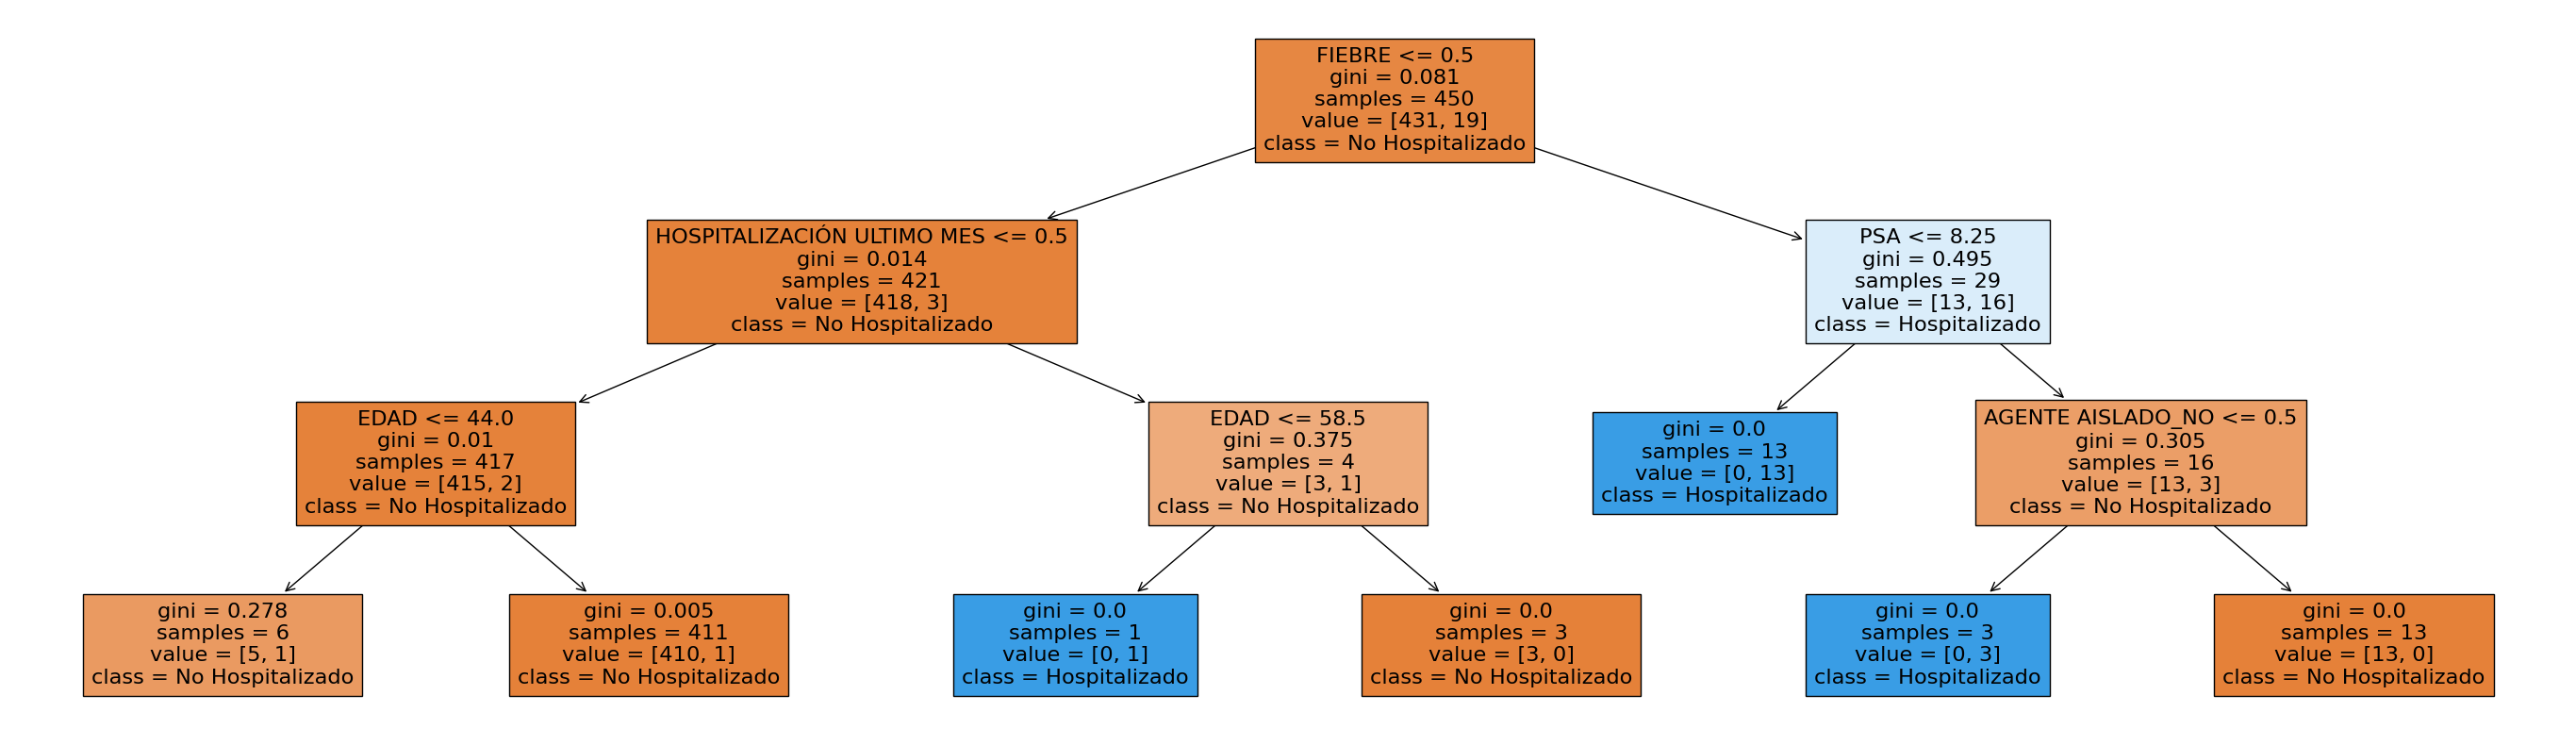

In [371]:
# Se crea una figura con un tamaño específico para mostrar el árbol de decisiones.
plt.figure(figsize=(35, 10))

# Se utiliza la función plot_tree para dibujar el árbol de decisiones entrenado.
tree.plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['No Hospitalizado', 'Hospitalizado'])

# Se muestra el árbol de decisiones.
plt.show()

In [372]:
# Realizar predicciones en los datos de prueba.
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0])

In [373]:
# Matriz de confusion.
cm = confusion_matrix(y_test, y_pred)
cm

# Verdaderos negativos (TN): 108
# Falsos positivos (FP): 0
# Falsos negativos (FN): 0
# Verdaderos positivos (TP): 5
# El modelo hizo 108 predicciones correctas de pacientes que no requirieron hospitalización,
# y 5 predicciones correctas de pacientes que sí requirieron hospitalización.

array([[108,   0],
       [  0,   5]])

In [374]:
# Calcular la precisión del clasificador.
accuracy = accuracy_score(y_test, y_pred)

print("Precisión del clasificador de árbol de decisión:", accuracy)

Precisión del clasificador de árbol de decisión: 1.0


In [375]:
# Puntaje de precisión.
precision_score(y_test, y_pred)

# Todas las predicciones positivas fueron correctas, no hubo falsos positivos en las predicciones.

1.0

In [376]:
# Definir el modelo XGBoost
xgb_model = xgb.XGBClassifier()

# Definir la grilla de hiperparámetros
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2]
}

# Se utiliza la búsqueda de hiperparámetros para encontrar la mejor combinación de valores de hiperparámetros
# para un problema específico.

# learning_rate: Es la tasa de aprendizaje que controla la contribución de cada árbol al modelo.
# Un valor más bajo generalmente conduce a una mejor generalización, pero puede requerir más árboles en el ensamble.

# max_depth: Es la profundidad máxima de cada árbol en el ensamble. Controla la complejidad del modelo y puede
# ayudar a prevenir el sobreajuste.

# n_estimators: Es el número de árboles en el ensamble. Cuantos más árboles, más complejo será el modelo y
# más tiempo tomará entrenarlo.

# gamma: Es un parámetro de regularización que controla cuánto se requiere disminuir la función de pérdida
# para que se considere una división adicional en el árbol. Un valor más alto conduce a una mayor conservación de los árboles.

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')


In [377]:
# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Los hiperparámetros óptimos sugieren que un modelo con una profundidad de árbol relativamente baja (3),
# una tasa de aprendizaje moderada (0.1) y un número moderado de árboles (100) logran un rendimiento óptimo
# en este conjunto de datos. Además, el valor de gamma de 0 indica que no se aplicó regularización adicional
# para la complejidad del modelo.
print("Mejores hiperparámetros encontrados:", best_params)

Mejores hiperparámetros encontrados: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [378]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Realizar predicciones en los datos de prueba
y_pred_xgb = best_model.predict(X_test)

print("Precisión del modelo XGBoost:", y_pred_xgb)

Precisión del modelo XGBoost: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0]


In [379]:
# Calcular la precisión del modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# El modelo clasifica correctamente el 98.23% de las muestras en el conjunto de prueba.
print("Precisión del modelo XGBoost:", accuracy_xgb)

Precisión del modelo XGBoost: 0.9823008849557522


In [380]:
# Definir el rango de valores para el hiperparámetro max_depth
param_range = [3, 4, 5, 6, 7]

# Calcular las puntuaciones de validación para el hiperparámetro max_depth
train_scores, test_scores = validation_curve(
    estimator=xgb_model,
    X=X_train,
    y=y_train,
    param_name='max_depth',
    param_range=param_range,
    cv=5
)

In [381]:
# Calcular las medias y desviaciones estándar de las puntuaciones de entrenamiento y prueba
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

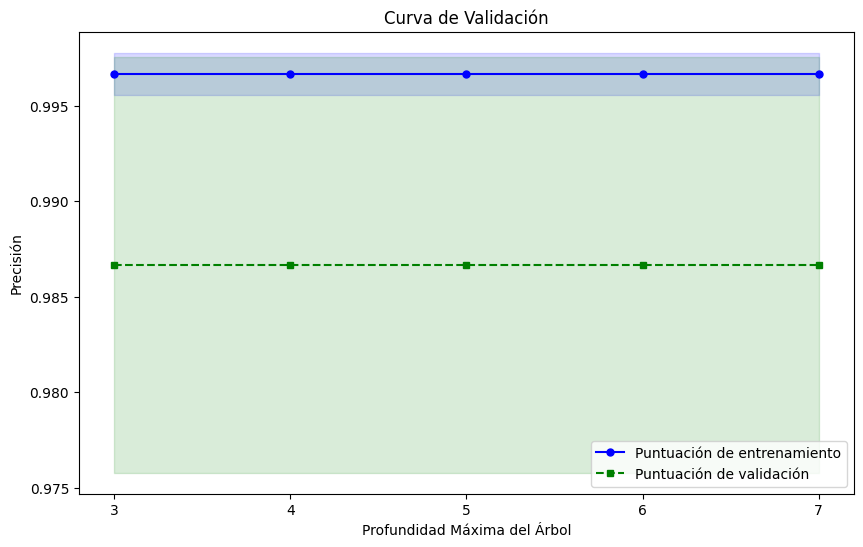

In [382]:
# Graficar las curvas de validación
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Puntuación de entrenamiento')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue') # Representa la variabilidad de la precisión del modelo.
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Puntuación de validación')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Curva de Validación')
plt.xlabel('Profundidad Máxima del Árbol')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.xticks(param_range)
plt.show()

In [383]:
# Calcular la exactitud del modelo, mide la proporción de predicciones correctas
# entre todas las predicciones realizadas por el modelo.
accuracy = accuracy_score(y_test, y_pred_xgb)

# La exactitud del modelo es del 98.23%, lo que indica que el 98.23% de las predicciones realizadas por el modelo son correctas.
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.9823008849557522


In [384]:
# # Calcular la precisión, que mide la proporción de verdaderos positivos respecto
# a todas las instancias positivas reales.
precision = precision_score(y_test, y_pred_xgb)

# El 80% de las instancias positivas que el modelo identificó como positivas fueron realmente positivas.
print("Precisión (precision) del modelo:", precision)

Precisión (precision) del modelo: 0.8


In [385]:
# Calcular el recall, que mide la proporción de verdaderos positivos respecto a todas las instancias positivas reales.
recall = recall_score(y_test, y_pred_xgb)

# El modelo identificó correctamente el 80% de todas las instancias positivas reales.
print("Recall del modelo:", recall)

Recall del modelo: 0.8


In [386]:
# Calcular la matriz de confusión, proporciona una visión más detallada de los resultados del modelo,
# mostrando el número de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
cm = confusion_matrix(y_test, y_pred_xgb)

# En la matriz de confusión, se observa que el modelo clasificó correctamente 107 muestras como negativas
# y 4 muestras como positivas. Sin embargo, se equivocó al clasificar una muestra como negativa cuando en
# realidad era positiva, y una muestra como positiva cuando en realidad era negativa. Esto indica que el
# modelo tiene un buen desempeño en la clasificación tanto de muestras positivas como negativas, con
# solo un par de errores de clasificación.
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[107   1]
 [  1   4]]
